# Task outcomes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.font_manager as font_manager
from collections import OrderedDict
from matplotlib import gridspec
import pandas as pd
import yaml
import datetime

prop = matplotlib.font_manager.FontProperties(fname="c:\\windows\\fonts\\nunitosans-light.ttf")
matplotlib.rcParams['font.family'] = prop.get_name()
matplotlib.rcParams['font.weight'] = 'light'
matplotlib.rcParams['axes.facecolor'] = 'white'

np.random.seed(10)

This notebook creates the outcomes for each trial in the task.

The task is a simple reversal learning task with one reversal. Shock probabilities are set to 80% and 20% for each branch of the tree.

## Settings

In [2]:
n_trials = [50, 50]  # number of trials per block
shock_prob = [0.7, 0.3] # High shock probability, low shock probability
n_outcome_only_trials = [13, 13]  # Number of "outcome only" trials per block (where subject doesn't make a response but passively views a trajectory and its outcome)
config_file = '../replay_task_settings.yaml'

with open(config_file) as f:
    config = yaml.load(f)

## Create the outcomes

In [3]:
block_dfs = []

# Loop over blocks
for i in range(len(n_trials)):

    # Index for selecting probability levels
    prob_idx = i % 2
    
    # Create shock / no-shock outcomes
    A_outcomes = np.hstack([np.ones(int(n_trials[i] * shock_prob[prob_idx])), 
                            np.zeros(int(n_trials[i] * shock_prob[1 - prob_idx]))])
    np.random.shuffle(A_outcomes)
    B_outcomes = 1 - A_outcomes  # Other stimulus outcomes are the inverse of the first stimulus

    shock_outcomes = {'0_shock': A_outcomes, '1_shock': B_outcomes,
                     '0_shock_probability': shock_prob[prob_idx], '1_shock_probability': shock_prob[1 - prob_idx]}

    # Put these into a pandas dataframe
    trial_info = pd.DataFrame(shock_outcomes)
    
    # Assign a random end state for each trial - this is used if subjects don't enter moves successfully, or on outcome only trials
    trial_info['end_state'] = np.random.randint(5, 7, len(trial_info))

    # Add outcome only trials
    trial_type = np.hstack([np.ones(n_outcome_only_trials[i]), np.zeros(n_trials[i] - n_outcome_only_trials[i])])
    np.random.shuffle(trial_type)
    if n_outcome_only_trials[i] > 0:
        trial_info['trial_type'] = trial_type
    else:
        trial_info['trial_type'] = 0

    block_dfs.append(trial_info)

# Combine block dataframes
trial_info = pd.concat(block_dfs).reset_index(drop=True)

# Add trial numbers
trial_info['trial_number'] = range(0, len(trial_info))
        

In [4]:
trial_info.head()

,0_shock,0_shock_probability,1_shock,1_shock_probability,end_state,trial_type,trial_number
0,0.0,0.7,1.0,0.3,5,0.0,0
1,1.0,0.7,0.0,0.3,5,0.0,1
2,0.0,0.7,1.0,0.3,5,1.0,2
3,0.0,0.7,1.0,0.3,5,0.0,3
4,0.0,0.7,1.0,0.3,6,1.0,4


### Information about task duration

In [5]:
durations = config['MEG_durations']

trial_duration = durations['start_duration'] + durations['pre_move_duration'] + \
                 durations['move_entering_duration'] + durations['pre_move_fixation_duration'] + \
                 np.sum(durations['move_durations']) + durations['rest_duration']

print "Trial duration = {0}".format(str(datetime.timedelta(seconds=trial_duration)))

oo_trial_duration = durations['outcome_only_text_duration'] + \
                    durations['outcome_only_duration'] + durations['rest_duration']

print "Outcome only trial duration = {0}".format(str(datetime.timedelta(seconds=oo_trial_duration)))

total_duration = (np.sum(n_trials) - np.sum(n_outcome_only_trials)) * trial_duration + np.sum(n_outcome_only_trials) * oo_trial_duration

print "Total task duration = {0}".format(str(datetime.timedelta(seconds=total_duration)))

Trial duration = 0:00:27.100000
Outcome only trial duration = 0:00:11
Total task duration = 0:38:11.400000


## Plot the outcomes

Here we plot the outcomes for each trial (shock = 1, no shock = 0), the objective shock probability level, and the outcome only trials (marked as grey vertical lines). Orange dotted lines represent breaks.

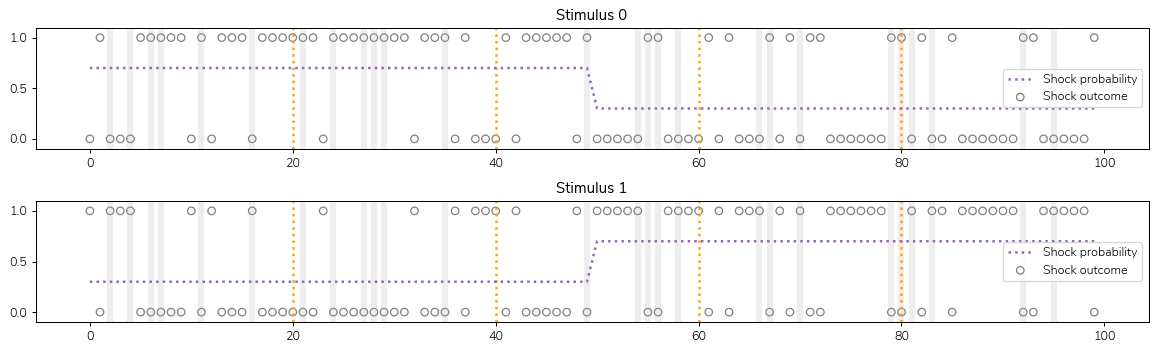

In [6]:
f, ax = plt.subplots(2, figsize=(13, 4), dpi=90)
for i in range(2):  # 2 stimuli
    
    for j in range(len(trial_info)):
        # Outcome only trials
        if trial_info.trial_type.values[j]:
            ax[i].axvline(j, linestyle='-', color='#adadad', linewidth=5, alpha=0.2)
        # Breaks
        if j > 0 and not j % config['MEG_durations']['trials_per_block']:
            ax[i].axvline(j, linestyle=':', color='orange', linewidth=2, alpha=1)
    
    # Probability line
    ax[i].plot(trial_info['{0}_shock_probability'.format(i)], label='Shock probability', linestyle=':', color='tab:purple', linewidth=2)
    
    # Outcomes
    ax[i].scatter(range(len(trial_info)), trial_info['{0}_shock'.format(i)], label='Shock outcome', facecolor='none', edgecolors='gray')
        
    ax[i].legend()
    ax[i].set_title("Stimulus {0}".format(i))
    ax[i].set_ylim(-0.1, 1.1)
    
plt.tight_layout()

## Save the outcomes

In [7]:
trial_info.to_csv('trial_info.csv', index=False)